In [18]:
# MNIST Self-Meta Model Notebook
# Reference: kwik-meta-new-int-meta-head.ipynb structure
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, activation='relu'):
        super().__init__()
        layers = []
        act = nn.ReLU if activation == 'relu' else nn.Tanh
        # input
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(act())
        # hidden
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class SelfMetaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, activation='relu'):
        super().__init__()
        self.backbone = FFNN(input_dim, hidden_dim, n_layers, activation)
        self.base_head = nn.Linear(hidden_dim, output_dim)
        self.meta_head = nn.Sequential(
            FFNN(output_dim, hidden_dim, 1, activation),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # x: (B, input_dim)
        h = self.backbone(x)
        base_logits = self.base_head(h)
        meta_output = self.meta_head(base_logits)
        return base_logits, meta_output


In [20]:
# Hyperparameters for model
input_dim = 28 * 28
hidden_dim = 512
output_dim = 10
n_layers = 2
activation = 'relu'

model = SelfMetaModel(input_dim, hidden_dim, output_dim, n_layers, activation).to(device)
model


SelfMetaModel(
  (backbone): FFNN(
    (model): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (base_head): Linear(in_features=512, out_features=10, bias=True)
  (meta_head): Sequential(
    (0): FFNN(
      (model): Sequential(
        (0): Linear(in_features=10, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (1): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [21]:
# Data
# Avoid Lambda in transform (not picklable with workers) and flatten in-loop
transform = transforms.Compose([
    transforms.ToTensor(),
])

root = os.path.expanduser('~/.data')
train_set = datasets.MNIST(root=root, train=True, download=True, transform=transform)
test_set = datasets.MNIST(root=root, train=False, download=True, transform=transform)

batch_size = 128
pin_mem = torch.cuda.is_available()
# Set num_workers=0 in notebooks to avoid multiprocessing/pickling issues on macOS
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin_mem)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin_mem)

len(train_set), len(test_set)


(60000, 10000)

In [ ]:
# Training utilities
ce_reduction_none = nn.CrossEntropyLoss(reduction='none')
l1_reduction_mean = nn.L1Loss(reduction='mean')

learning_rate = 1e-3
weight_decay = 0.0
epochs = 3

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total = 0
    correct = 0
    all_true = []
    all_meta = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        x = x.view(x.size(0), -1)
        base_logits, meta_output = model(x)
        preds = base_logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        # per-sample base loss and meta pred for the true class
        base_loss_ps = ce_reduction_none(base_logits, y)  # (B,)
        meta_trueclass = meta_output.gather(1, y.view(-1, 1)).squeeze(1)
        all_true.append(base_loss_ps.detach().cpu())
        all_meta.append(meta_trueclass.detach().cpu())
    acc = correct / total
    true_losses = torch.cat(all_true)
    meta_losses = torch.cat(all_meta)

    if true_losses.numel() < 2:
        corr = float('nan')
    else:
        # Use numpy correlation as fallback for compatibility
        try:
            corr = np.corrcoef(true_losses.numpy(), meta_losses.numpy())[0, 1]
        except:
            corr = float('nan')
    return acc, corr

for epoch in range(1, epochs + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        # flatten inside loop: (B, 1, 28, 28) -> (B, 784)
        x = x.view(x.size(0), -1)
        base_logits, meta_output = model(x)
        # base CE per-sample
        base_loss_ps = ce_reduction_none(base_logits, y)  # (B,)
        base_loss = base_loss_ps.mean()
        # meta predicts per-class loss; supervise using one-hot selection of true class
        meta_trueclass = meta_output.gather(1, y.view(-1, 1)).squeeze(1)  # (B,)
        meta_loss = l1_reduction_mean(meta_trueclass, base_loss_ps.detach())
        loss = base_loss + meta_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item(), base=base_loss.item(), meta=meta_loss.item())
    train_acc, train_corr = evaluate(train_loader)
    test_acc, test_corr = evaluate(test_loader)
    print(f"Train acc: {train_acc:.4f}, corr: {train_corr:.3f} | Test acc: {test_acc:.4f}, corr: {test_corr:.3f}")


Epoch 1/3: 100%|██████████| 469/469 [00:03<00:00, 135.79it/s, base=0.165, loss=0.236, meta=0.0709] 


Train acc: 0.9616, corr: 0.967 | Test acc: 0.9595, corr: 0.963


Epoch 2/3: 100%|██████████| 469/469 [00:03<00:00, 137.20it/s, base=0.0664, loss=0.124, meta=0.0575] 


Train acc: 0.9741, corr: 0.980 | Test acc: 0.9688, corr: 0.981


Epoch 3/3: 100%|██████████| 469/469 [00:03<00:00, 138.06it/s, base=0.0383, loss=0.104, meta=0.0661] 


Train acc: 0.9828, corr: 0.972 | Test acc: 0.9764, corr: 0.974


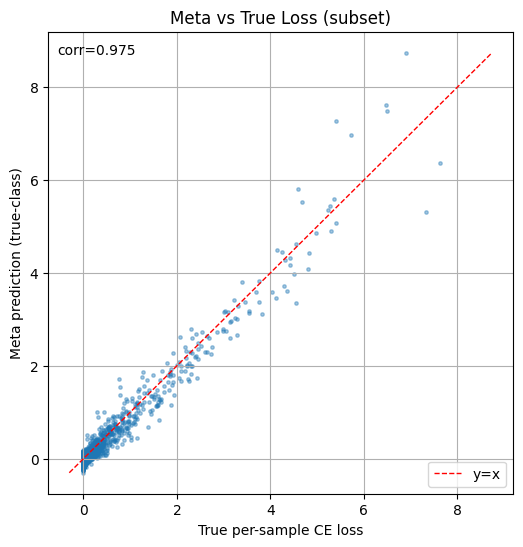

Base model accuracy on subset: 0.9720


In [25]:
# Evaluation plots
@torch.no_grad()
def collect_losses(loader, limit_batches=None):
    model.eval()
    xs = []
    ys = []
    meta = []
    preds_all = []
    targets_all = []
    cnt = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        x = x.view(x.size(0), -1)
        base_logits, meta_logits = model(x)
        base_loss_ps = ce_reduction_none(base_logits, y)
        meta_trueclass = meta_logits.gather(1, y.view(-1, 1)).squeeze(1)
        xs.append(base_loss_ps.cpu())
        ys.append(y.cpu())
        meta.append(meta_trueclass.cpu())
        # For accuracy: take prediction from base head
        base_preds = base_logits.argmax(dim=1)
        preds_all.append(base_preds.cpu())
        targets_all.append(y.cpu())
        cnt += 1
        if limit_batches and cnt >= limit_batches:
            break
    # Compute base model accuracy
    all_preds = torch.cat(preds_all)
    all_targets = torch.cat(targets_all)
    base_acc = (all_preds == all_targets).float().mean().item()
    return torch.cat(xs), torch.cat(meta), base_acc

true_l, meta_l, base_acc = collect_losses(test_loader, limit_batches=50)
plt.figure(figsize=(6,6))
plt.scatter(true_l.numpy(), meta_l.numpy(), s=6, alpha=0.4)
# Add y=x line for reference
lims = [
    np.min([true_l.min().item(), meta_l.min().item()]),
    np.max([true_l.max().item(), meta_l.max().item()])
]
plt.plot(lims, lims, 'r--', linewidth=1, label="y=x")
plt.xlabel('True per-sample CE loss')
plt.ylabel('Meta prediction (true-class)')
plt.title('Meta vs True Loss (subset)')
plt.grid(True)
if true_l.numel() > 1:
    corr = np.corrcoef(true_l.numpy(), meta_l.numpy())[0,1]
    plt.annotate(f"corr={corr:.3f}", (0.02, 0.95), xycoords='axes fraction')
plt.legend()
plt.show()
print(f"Base model accuracy on subset: {base_acc:.4f}")


In [30]:
# Print correlation on test set
test_acc, test_corr = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Correlation: {test_corr:.4f}")


Test Accuracy: 0.9764
Test Correlation: 0.9745
